In [69]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
import os 
from functions import *
from enrichment import *
from matplotlib_venn import venn2, venn3
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats
import seaborn as sns
import squarify
import matplotlib.patches as mpatches

# Load dataset

In [2]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])

ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])

In [3]:
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
all_genes = list(S.index)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
IM_list = list(S.columns)

regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [4]:
orig_var = (log_rpkm_norm**2).sum().sum()
err_var = ((log_rpkm_norm.values - (S.values).dot(A.values) )**2).sum().sum()
print('Explained variance: {:.2f}'.format(1-err_var/orig_var))

Explained variance: 0.85


# IM gene identification

In [5]:
IM_thersholds = {}
for im in IM_list:
    IM_thersholds[im] = compute_threshold(S, im ,cutoff=550)

In [6]:
# IMs = {}
# for im in IM_list:
#     temp_pd = S[abs(S[im]) >= IM_thersholds[im] ]
#     IMs[im] = list(temp_pd.index)
# dump_pickle(IMs, '../data/IMdata/imodulon_genes.pkl')

In [7]:
IMs = load_pickle('../data/IMdata/imodulon_genes.pkl')
IM_annotation = pd.read_csv('../data/IMdata/IM_annotation.csv')

Text(0, 0.5, 'Number')

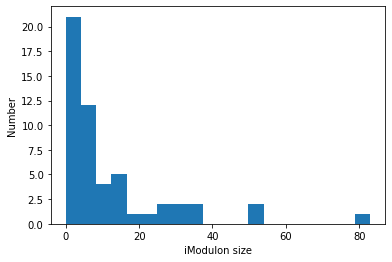

In [12]:
empty_IMs = []
for im in IMs:
    if len(IMs[im]) == 0:
        empty_IMs.append(im)
IM_sizes = [len(IMs[im]) for im in IMs]
plt.hist(IM_sizes,bins=20);
plt.xlabel('iModulon size')
plt.ylabel('Number')

In [10]:
print(empty_IMs)

['3', '13', '22', '24', '29', '37', '50', '51']


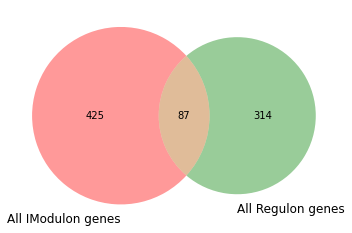

In [11]:
all_im_genes, all_reg_genes = [],[]
for im in IMs:
    all_im_genes += IMs[im]
all_im_genes = set(all_im_genes)
for reg in regulons:
    all_reg_genes += regulons[reg]
all_reg_genes = set(all_reg_genes)
venn2([all_im_genes, all_reg_genes], set_labels=['All IModulon genes','All Regulon genes'])

# Regulon enrichment

In [25]:
IMwRF = []
Annotations = {}
for k in IMs:
    if sum(trn.gene_id.isin( IMs[k] ) ) > 0:
        IMwRF.append( k )
for im in IMwRF:
    result = compute_trn_enrichment(IMs[im], list(S.index), trn )
    if len(result.index) < 1:
        continue
    result = result.sort_values(by='TP',ascending=False)
    if len(result.index) > 2:
        Annotations[im] = list( result.index )[0:2]
    else:
        Annotations[im] = list( result.index )

(0.0, 1.0, 0.0, 1.0)

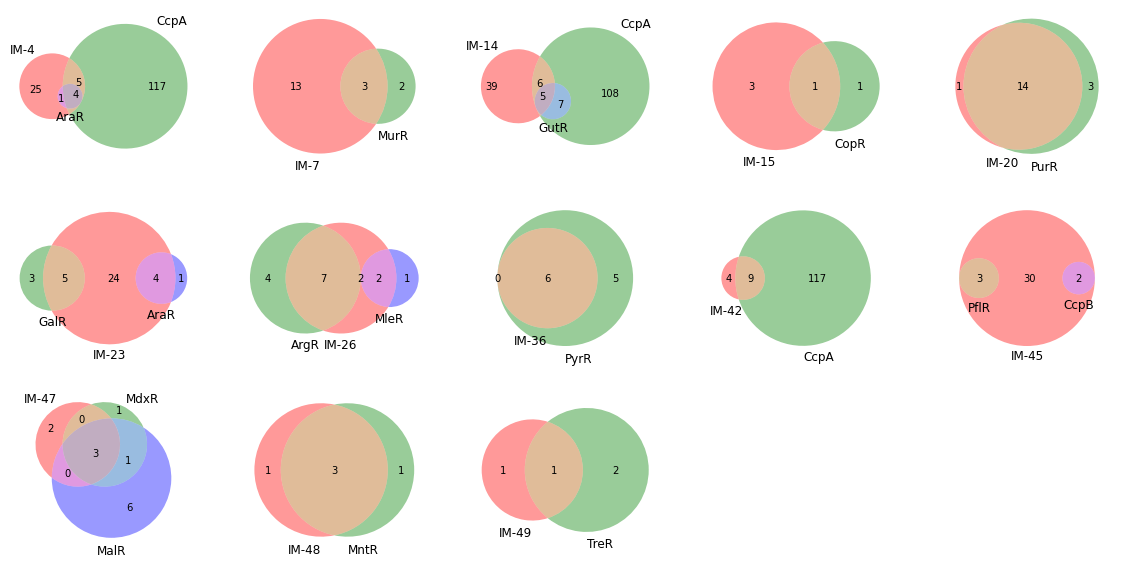

In [26]:
fig, axs = plt.subplots(3,5,figsize=(20,10))
for i in range(len(Annotations.keys())):
    im = list(Annotations.keys())[i]
    x,y = int(i/5), int(i%5)
    if len(Annotations[im]) == 2:
        venn3([set(IMs[im]),set(regulons[Annotations[im][0]]), set(regulons[Annotations[im][1]])],
             set_labels=['IM-'+im,Annotations[im][0],Annotations[im][1] ] , ax = axs[x][y])
    else:
        venn2( [set(IMs[im]),set(regulons[Annotations[im][0]])],
             set_labels=['IM-'+im,Annotations[im][0] ], ax = axs[x][y])
axs[2][3].axis('off')
axs[2][4].axis('off')

In [23]:
IM_annotation.head()

,IM,Regulator annotation,Method,Function
0,0,_,_,Prophage
1,1,Fur/LexA,motif,Stress
2,2,Fur,motif,_
3,4,CcpA+AraR,enrichment,Carbohydrate metabolism
4,5,_,_,Prophage


In [86]:
color_assign = { 'Amino Acid metabolism': 'tab:orange', 'Carbohydrate metabolism':sns.color_palette("Paired")[0],
       'Carbohydrate metabolism/Cell wall biogenesis':sns.color_palette("Paired")[0],
       'Cell wall biogenesis':'tab:blue', 'Coenzyme metabolism':'tab:purple',
        'Energy metabolism':'tab:green',
       'Inorganic ion metabolism':'tab:brown', 'Lipid metabolism':'wheat',
       'Nucleotide metabolism':'peru', 'Prophage':'salmon', 'Stress':'tab:red', 
        'Transcription':'violet','Translation':'magenta' }

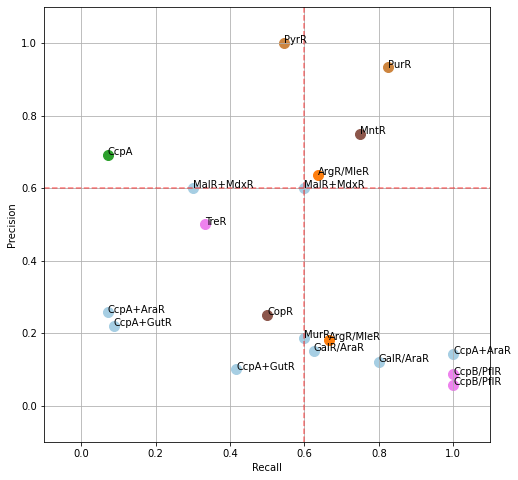

In [87]:
fig, ax = plt.subplots(figsize=(8,8))
for im in IMwRF:
    result = compute_trn_enrichment(IMs[im], list(S.index), trn )
    if len(result.index) < 1:
        continue
    result = result.sort_values(by='TP',ascending=False)
    if len(result.index) < 2:
        annot = list( IM_annotation[IM_annotation['IM']==int(im)]['Regulator annotation'])[0]
        func = list( IM_annotation[IM_annotation['IM']==int(im)]['Function'])[0]
        if func == '-':
            color = 'grey'
        else:
            color = color_assign[func]
        
        ax.scatter(list(result['recall'])[0], list(result['precision'])[0], s=100, color=color)
        ax.annotate( annot, ( list(result['recall'])[0] , list(result['precision'])[0] ))
    else:
        for i in range(2):
            annot = list( IM_annotation[IM_annotation['IM']==int(im)]['Regulator annotation'])[0]
            func = list( IM_annotation[IM_annotation['IM']==int(im)]['Function'])[0]
            if func == '-':
                color = 'grey'
            else:
                color = color_assign[func]
            ax.scatter(list(result['recall'])[i], list(result['precision'])[i], s=100, color=color)
            ax.annotate( annot, ( list(result['recall'])[i] , list(result['precision'])[i] ))
ax.grid()
ax.set_xlim([-0.1,1.1]);  ax.set_ylim([-0.1,1.1]);
ax.set_xlabel('Recall'); ax.set_ylabel('Precision');
ax.axhline(y=0.6, color='r', linestyle='--',alpha=0.5)
ax.axvline(x=0.6, color='r', linestyle='--',alpha=0.5)

In [ ]:
# IM-19 is translation IM

# Annotation by motif search

In [41]:
def save_dict_fasta( seq_dict, out_path ):
    records = []
    for k in seq_dict:
        records.append( SeqRecord(Seq(seq_dict[k]), id = k, name="",description="") )
    SeqIO.write(records, out_path ,"fasta")

In [42]:
for im in IMs.keys():
    if ( im not in Annotations.keys() ) and ( im not in empty_IMs ):
        promoter_dict = get_im_promoters(IMs[im], '../data/genome/sequence.fna', gb_features, ref_features)
        if len(promoter_dict.keys()) > 1:
            save_dict_fasta( promoter_dict, '../data/MEME_results/im'+im+'_promoters.fasta' )

In [ ]:
# lp_3580 is annotated as AgrA by egg mapper.

# Functional annotation

In [11]:
egg_results = pd.read_csv('../data/genome/functional_annotations.csv')

In [12]:
def get_cogs(gene_set, table ):
    out = {'-':0}
    for gene in gene_set:
        if gene not in list( table['query'] ):
            out['-'] += 1
        else:
            temp_pd = table[table['query']==gene].reset_index()
            cogs = list( list(temp_pd['COG_category'])[0] )
            for cog in cogs:
                if cog in out:
                    out[cog] += 1
                else:
                    out[cog] = 1
    return out
                

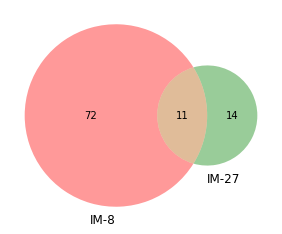

In [112]:
venn2([set(IMs['8']),set(IMs['27'])],set_labels=['IM-8','IM-27'])

# Visualize annotation status

In [65]:
IM_annotation = ( IM_annotation.sort_values(['Function']) ).reset_index().drop(['index'],axis=1)

Text(0.5, 1.0, 'Regulatory annotation status')

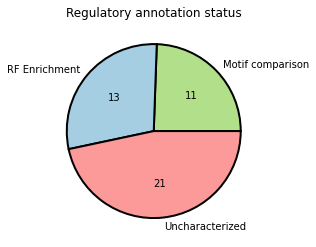

In [66]:
colors = [sns.color_palette("Paired")[2], sns.color_palette("Paired")[0],sns.color_palette("Paired")[4]]
annot_methods = {'Motif comparison': list(IM_annotation['Method']).count('motif'),
                'RF Enrichment':list(IM_annotation['Method']).count('enrichment'),
                'Uncharacterized':list(IM_annotation['Method']).count('_') }
def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{v:d}'.format(v=val)
    return my_format

fig,ax = plt.subplots(1,1)
ax.pie(annot_methods.values(), labels=annot_methods.keys(), autopct =  autopct_format(annot_methods.values()),
           wedgeprops = {"edgecolor" : "black",'linewidth': 2,'antialiased': True},colors=colors);
ax.set_title('Regulatory annotation status')

In [84]:
color_assign = { 'Amino Acid metabolism': 'tab:orange', 'Carbohydrate metabolism':sns.color_palette("Paired")[0],
       'Carbohydrate metabolism/Cell wall biogenesis':sns.color_palette("Paired")[0],
       'Cell wall biogenesis':'tab:blue', 'Coenzyme metabolism':'tab:purple',
        'Energy metabolism':'tab:green',
       'Inorganic ion metabolism':'tab:brown', 'Lipid metabolism':'wheat',
       'Nucleotide metabolism':'peru', 'Prophage':'salmon', 'Stress':'tab:red', 
        'Transcription':'violet','Translation':'magenta' }
labels, sizes, color_list = [],[],[]
for i in range(len(IM_annotation.index)):
    sizes.append( len(set(IMs[ str( list(IM_annotation['IM'])[i])  ])) )
    func_annot = list( IM_annotation['Function'] )[i]
    if (list(IM_annotation['Regulator annotation'])[i] == '_') :
        labels.append( 'IM-'+str( list(IM_annotation['IM'])[i]) )
    else:
        labels.append( list( IM_annotation['Regulator annotation'] )[i] )
        
    
    
    if func_annot == '_':
        color_list.append( 'grey' )
    else:
        color_list.append( color_assign[func_annot] )

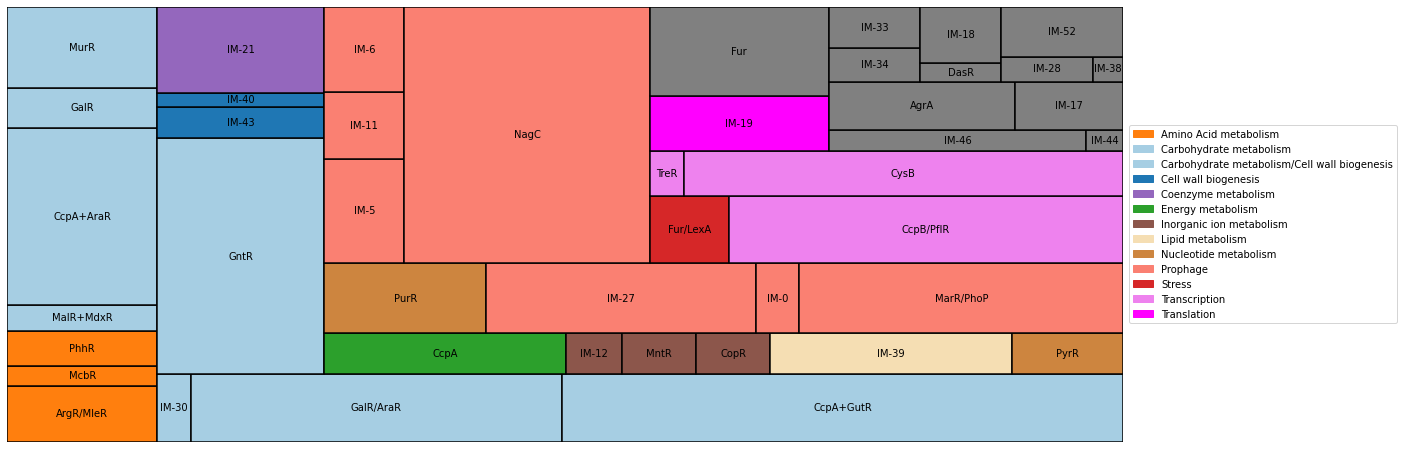

In [91]:
handles = []
for func in color_assign.keys():
    handles.append( mpatches.Patch(color= color_assign[func], label=func))
    
fig, ax = plt.subplots(1,1, figsize=(20,8))
squarify.plot( label = labels, sizes = sizes, color = color_list,
              edgecolor="black", linewidth=1.5, ax=ax);
ax.axis('off');
ax.legend(handles=handles,loc='right',bbox_to_anchor=[1.25, 0.5])